In [14]:
import hilbertcurve
import nglview
import numpy as np
import py3Dmol
from hilbertcurve.hilbertcurve import HilbertCurve
# import openmm
import pytraj as pt 
import matplotlib.pyplot as plt
from matplotlib import cm


/tmp/ipykernel_56180/285973429.py:23: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


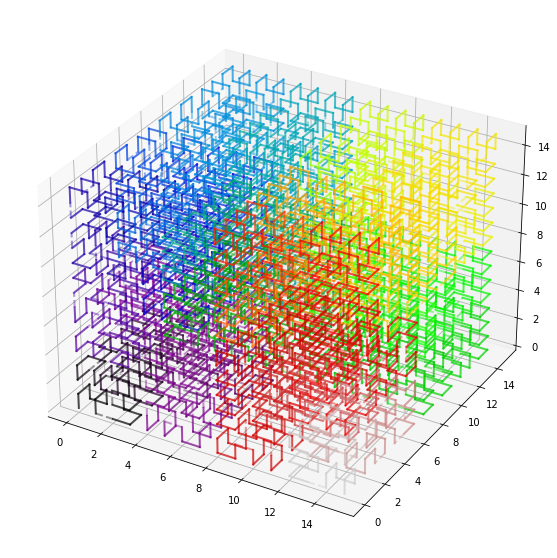

In [17]:
with open("rec.pdb","r") as file1:
    pdbfile = [i.strip('\n') for i in  file1.readlines()] #.split('\n')
with open("trajLigand.mol2","r") as file2:
    molfile = [i.strip('\n') for i in file2.readlines()]
# print(molfile)

ite=4; 
dim=3;
cutoff=14;


hilbert_curve = HilbertCurve(ite, dim)
distances = list(range(2**(ite*dim)))
points = hilbert_curve.points_from_distances(distances)
# print(points)

x = [pt[0] for pt in points]
y = [pt[1] for pt in points]
z = [pt[2] for pt in points]


fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
cmap = cm.nipy_spectral
s = 1
for i in range(len(points)):
    if (i+1) % 8 == 0:
        linestyle='--'
        linewidth=2
        alpha=0.4
    else:
        linestyle = '-'
        linewidth=2
        alpha=0.7
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1],
            linestyle=linestyle, linewidth=linewidth, alpha=alpha,
            color=cmap(i/(len(points))))


In [51]:
traj = pt.load("rec.pdb")
print(dir(traj.top))
traj.top.set_reference(traj[0])

select1 = traj.top.select(":LIG <: 5")


ovcenter = np.mean(traj.xyz[0][traj.top.select(":LIG <: 5")], axis=0)
ligcenter = np.mean(traj.xyz[0][traj.top.select(":LIG")], axis = 0)

print(ovcenter)
print(ligcenter)




# vol = pt.atom_map(traj)
# print(vol)

ligCoor = traj.xyz[0][traj.top.select(":LIG & !@H*")]
proCoor = traj.xyz[0][traj.top.select(":* & !@H*, K, CL & !:LIG")]
c = traj.top.atom
print(len(ligCoor))
print(len(proCoor))
# for i in c:
#     print(i)
print(traj.top.summary())

['__add__', '__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__pyx_fuse_0add_angles', '__pyx_fuse_0add_bonds', '__pyx_fuse_0add_dihedrals', '__pyx_fuse_1add_angles', '__pyx_fuse_1add_bonds', '__pyx_fuse_1add_dihedrals', '__pyx_fuse_2add_angles', '__pyx_fuse_2add_bonds', '__pyx_fuse_2add_dihedrals', '__pyx_vtable__', '__radd__', '__reduce__', '__reduce_cython__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__setstate__', '__setstate_cython__', '__sizeof__', '__str__', '__subclasshook__', '_get_new_from_mask', '_indices_bonded_to', '_iter_mut', '_load', '_modify_state_by_mask', '_original_filename', '_own_memory', '_partial_modify_state_by_mask', '_set_integer_mask', '_total_charge', 'add_angles', 'add_atom', 'add_bonds', 'add_dihedrals',

In [88]:
# view = nglview.show_file("rec.pdb")
view = nglview.show_file("trajLigand.mol2")
view



SyntaxError: invalid syntax (4235197918.py, line 6)

In [90]:
traj = pt.datafiles.load_tz2_ortho()
vol = pt.volume(traj, '@CA')
print(vol)

[53370.07989848 53340.75205896 53332.52759063 53356.15921761
 53276.40269261 53277.02435214 53338.94154946 53307.68715816
 53365.90922305 53418.85444185]
